In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from matplotlib.ticker import PercentFormatter

In [2]:
df = pd.read_csv('flights_NY.csv')

In [3]:
df.head()

,year,month,day,dep_time,dep_delay,arr_time,arr_delay,carrier,tailnum,flight,origin,dest,air_time,distance
0,2013,1,1,517.0,2.0,830.0,11.0,UA,N14228,1545,EWR,IAH,227.0,1400
1,2013,1,1,533.0,4.0,850.0,20.0,UA,N24211,1714,LGA,IAH,227.0,1416
2,2013,1,1,542.0,2.0,923.0,33.0,AA,N619AA,1141,JFK,MIA,160.0,1089
3,2013,1,1,544.0,-1.0,1004.0,-18.0,B6,N804JB,725,JFK,BQN,183.0,1576
4,2013,1,1,554.0,-6.0,812.0,-25.0,DL,N668DN,461,LGA,ATL,116.0,762


In [4]:
df.shape[0]

336776

In [5]:
df = df.dropna()
df.shape[0]

327346

In [6]:
"""
1. For each airline, estimate the probability that the arrival delay will be positive
and draw a graph showing the distribution of this probability by airline.
"""
carriers = sorted(df['carrier'].unique())
delaysCount = {"carriers": [], "probability": []}
for carrier in carriers:
    carrierFlights = df.loc[df['carrier'] == carrier]
    carriersFlightsDelayed = carrierFlights.loc[carrierFlights['arr_delay'] > 0]
    delaysCount["carriers"].append(carrier)
    delaysCount["probability"].append(carriersFlightsDelayed.shape[0] / carrierFlights.shape[0])

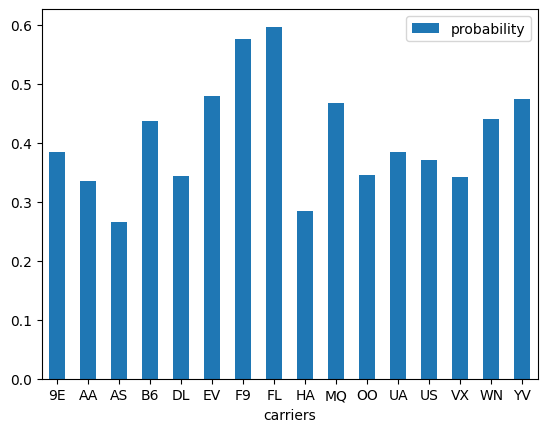

In [7]:
delayProbability = pd.DataFrame(delaysCount)
ax = delayProbability.plot.bar(x='carriers', y='probability', rot=0)

array([[<Axes: title={'center': 'distance'}>]], dtype=object)

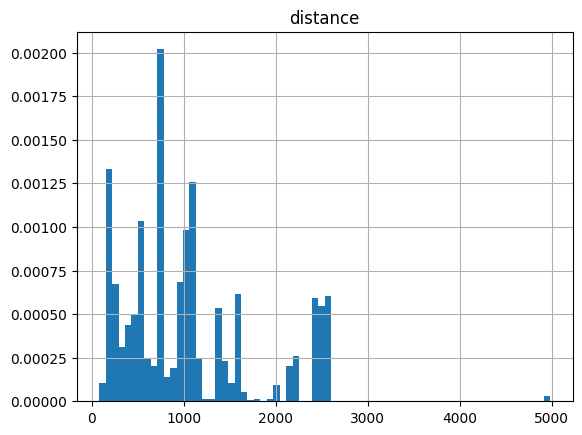

In [8]:
"""
2. Construct a histogram of the flight distance. Select three groups of flights: short, medium and long.
What distance values are reasonable to choose as the boundary separating short, medium and long flights?
Where do planes fly in a long flight group? Find the average departure delay time in each of the three selected groups.
"""
df.hist(column='distance', bins=70, density=True)

In [9]:
# short distance flights < 1200 miles
# middle distance flights from 1200 miles to 3000 miles
# long distance flights > 3000 miles

In [10]:
longDistanceFlights = df.loc[df['distance'] > 3000]
print(f"Long distance destinations: {longDistanceFlights['dest'].unique()}")

Long distance destinations: ['HNL' 'ANC']


In [11]:
print("Short distance flights delay:", df.loc[df['distance'] < 1200]['arr_delay'].mean())
print("Medium distance flights delay:", df.loc[(df['distance'] > 1200) & (df['distance'] < 3000)]['arr_delay'].mean())
print("Long distance flights delay:", longDistanceFlights['arr_delay'].mean())

Short distance flights delay: 8.496193246490451
Medium distance flights delay: 2.7147170317689286
Long distance flights delay: -1.377997179125529


In [12]:
"""
3. Draw a graph of the average departure delay time by month 
and mark the boundaries of the confidence intervals on it with a confidence level of 0.95.
Using a suitable statistical test, 
check whether the hypothesis of equality of means in January and February can be accepted 
at the significance level of 0.05 and 0.01?
"""
delaysByMonth = {"month": list(range(1, 13)), "delay": []}
for month in range(1, 13):
    delaysByMonth["delay"].append(df.loc[df['month'] == month]['arr_delay'].mean())

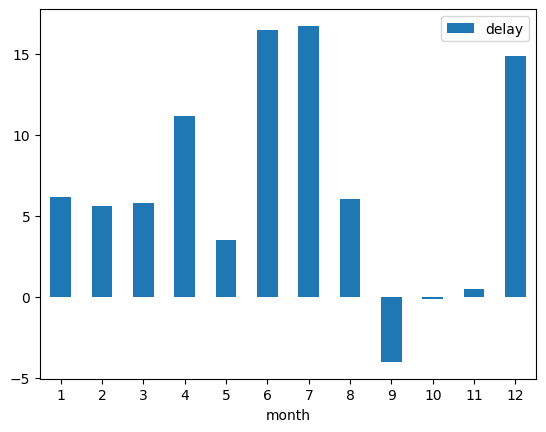

In [13]:
delay = pd.DataFrame(delaysByMonth)
ax = delay.plot.bar(x='month', y='delay', rot=0)

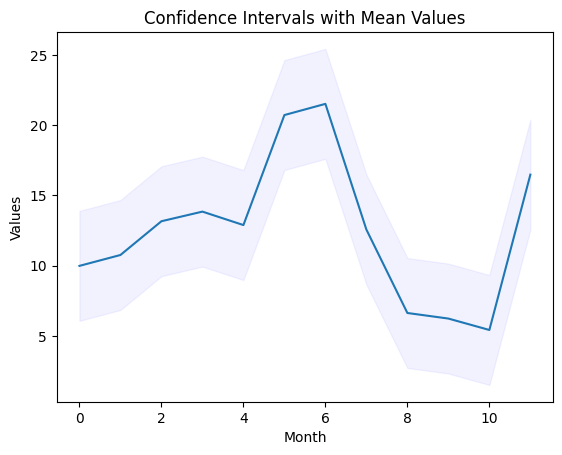

In [14]:
grouped_delays = df.groupby('month')['dep_delay'].mean().reset_index()
grouped_delays.columns = ['month', 'average_delay_time']

std_error = stats.sem(grouped_delays.average_delay_time)

lower_bound = grouped_delays.average_delay_time - std_error  *  stats.t.ppf((1 + 0.975) / 2, len(grouped_delays.average_delay_time) - 1)
upper_bound = grouped_delays.average_delay_time + std_error  *  stats.t.ppf((1 + 0.975) / 2, len(grouped_delays.average_delay_time) - 1)

plt.plot(grouped_delays.average_delay_time, label='Mean values')

# Adding confidence interval boundaries
plt.fill_between(range(len(grouped_delays.average_delay_time)), lower_bound, upper_bound, alpha=0.05, color='blue')
plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Confidence Intervals with Mean Values')
plt.show()

In [15]:
grouped_delays.head()

,month,average_delay_time
0,1,9.985491
1,2,10.760239
2,3,13.164289
3,4,13.849187
4,5,12.891709


In [16]:
january_data = grouped_delays.loc[grouped_delays['month'] == 1]['average_delay_time']
february_data = grouped_delays.loc[grouped_delays['month'] == 2]['average_delay_time']

t_stat, p_value = stats.ttest_ind(january_data, february_data)
print("At a significance level of 0.05, the hypothesis of equality of means is " + ("accepted." if p_value > 0.05 else "rejected."))

t_stat, p_value = stats.ttest_ind(january_data, february_data, alternative='less')
print("At a significance level of 0.01, the hypothesis of equality of means is " + ("accepted." if p_value > 0.01 else "rejected."))


At a significance level of 0.05, the hypothesis of equality of means is rejected.
At a significance level of 0.01, the hypothesis of equality of means is rejected.


C:\Users\sergi\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_stats_py.py:6951: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


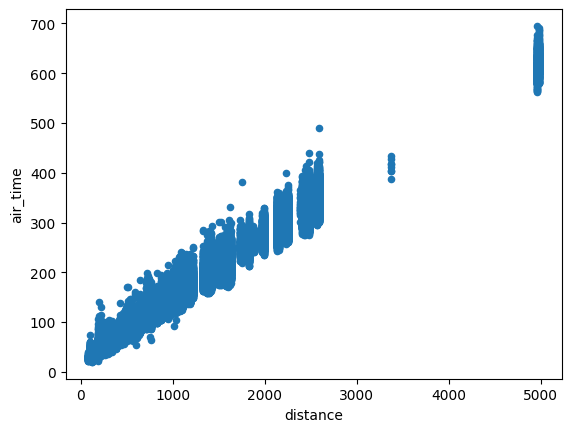

In [17]:
""" 4. Find the correlation coefficient between distance and flight time air_time.
Plot a scatter diagram in the distance (x) and air_time (y) axes.
Find the linear regression coefficients and plot the resulting straight line on a graph.
How can we interpret the meaning of the coefficients of the resulting linear model?"""
ax1 = df.plot.scatter(x='distance', y='air_time')

In [18]:
# calculate correlation coefficient = (mean(xy) - mean(x) * mean(y)) / (deviation(x) * deviation(y))
x_y_mean = 0
x_mean = 0
y_mean = 0
x_deviation = 0
y_deviation = 0
N = df.shape[0]
for x, y in zip(df['distance'], df['air_time']):
    x_y_mean += x * y
    x_mean += x
    y_mean += y
    x_deviation += x ** 2
    y_deviation += y ** 2
    
x_y_mean /= N
x_mean /= N
y_mean /= N
x_deviation /= N
x_deviation = (x_deviation - x_mean ** 2) ** 0.5
y_deviation /= N
y_deviation = (y_deviation - y_mean ** 2) ** 0.5
print(f"Correlation coefficient: {(x_y_mean - x_mean * y_mean) / (x_deviation * y_deviation)}")

Correlation coefficient: 0.9906496472248576


In [19]:
# check correlation coefficient using pandas method .corr()
df[["distance", "air_time"]].corr(method='pearson')

,distance,air_time
distance,1.00000,0.99065
air_time,0.99065,1.00000


In [20]:
# to find the linear regression coefficients we use the least squares method
x_sum = 0
squared_x_sum = 0
y_sum = 0
x_y_sum = 0
N = df.shape[0]
for x, y in zip(df['distance'], df['air_time']):
    x_sum += x
    squared_x_sum += x ** 2
    y_sum += y
    x_y_sum += x * y
# according to the Cramer's rule
det = (squared_x_sum * N) - (x_sum ** 2)
det_a = (x_y_sum * N) - (x_sum * y_sum)
a = det_a / det

det_b = (squared_x_sum * y_sum) - (x_y_sum * x_sum)
b = det_b / det
print(f"Coefficients of a linear regression y = ax + b: {a}, {b}")

Coefficients of a linear regression y = ax + b: 0.12611932467386067, 18.46657812776041


In [21]:
for key, el in df.head(10).iterrows():
    pred = el["distance"] * a + b
    print(f'x: {el["distance"]}, y: {el["air_time"]} ->  prediction: {pred}, relative error(%): {abs(pred - el["air_time"]) / el["air_time"] * 100}')

x: 1400, y: 227.0 ->  prediction: 195.03363267116535, relative error(%): 14.082100144861078
x: 1416, y: 227.0 ->  prediction: 197.05154186594712, relative error(%): 13.193153363018892
x: 1089, y: 160.0 ->  prediction: 155.81052269759468, relative error(%): 2.6184233140033264
x: 1576, y: 183.0 ->  prediction: 217.23063381376483, relative error(%): 18.705264379106463
x: 762, y: 116.0 ->  prediction: 114.56950352924224, relative error(%): 1.2331866127222066
x: 719, y: 150.0 ->  prediction: 109.14637256826623, relative error(%): 27.235751621155845
x: 1065, y: 158.0 ->  prediction: 152.78365890542202, relative error(%): 3.301481705429104
x: 229, y: 53.0 ->  prediction: 47.3479034780745, relative error(%): 10.664333060236793
x: 944, y: 140.0 ->  prediction: 137.52322061988488, relative error(%): 1.7691281286536562
x: 733, y: 138.0 ->  prediction: 110.91204311370028, relative error(%): 19.62895426543458


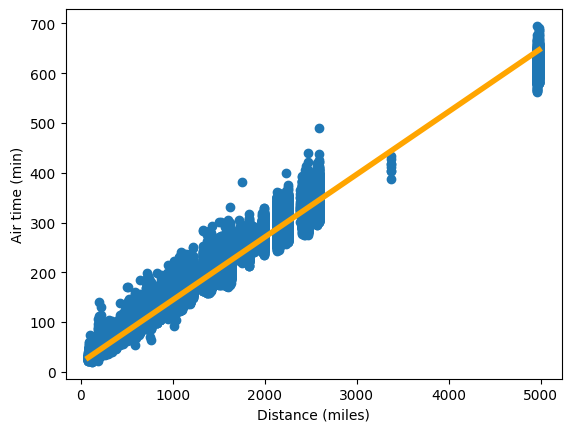

In [22]:
x = list(range(df["distance"].min(), df["distance"].max()))
plt.plot(x, [a*el + b for el in x], color="orange", linewidth=4)
plt.scatter(df["distance"], df["air_time"])

plt.xlabel('Distance (miles)')
plt.ylabel('Air time (min)')
plt.show()

In [23]:
"""
The meaning of linear regression coefficients: the slope coefficient is ≈ 0.12,
so if the flight distance increases, for example, by 1000 miles, the flight time will increase by 120 minutes.
That is, the average airplane speed is ≈ 500 mph.
In the case where flight distance = 0 miles, the linear regression value is 0.12 * 0 + 18 = 18 minutes.
It can be assumed that the average flight preparation time (safety briefing, departure to the runway, etc.) is 18 minutes.
"""

'\nThe meaning of linear regression coefficients: the slope coefficient is ≈ 0.12,\nso if the flight distance increases, for example, by 1000 miles, the flight time will increase by 120 minutes.\nThat is, the average airplane speed is ≈ 500 mph.\nIn the case where flight distance = 0 miles, the linear regression value is 0.12 * 0 + 18 = 18 minutes.\nIt can be assumed that the average flight preparation time (safety briefing, departure to the runway, etc.) is 18 minutes.\n'

In [24]:
""" 5. Construct a normalized histogram of the distribution of arrival delays
for those flights that departed within +/-15 minutes of the scheduled time.
Make an assumption about what distribution can describe the resulting histogram,
estimate the parameters of this distribution
and plot the density graph on the graph with the histogram.
"""

df = df.loc[(df['dep_delay'] >= -15) & (df['dep_delay'] <= 15)]
df = df.reset_index(drop=True)

Text(0, 0.5, '% of flights')

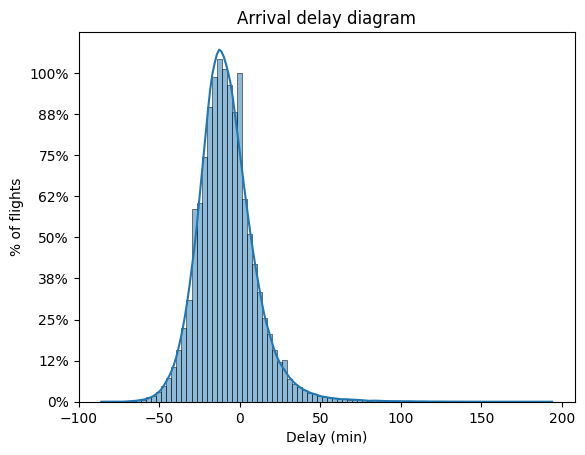

In [25]:
sns.histplot(df['arr_delay'], kde=True, bins=int(180/2))
# Percent formatting 
plt.gca().yaxis.set_major_formatter(PercentFormatter(20000))
plt.title('Arrival delay diagram')
plt.xlabel('Delay (min)')
plt.ylabel('% of flights')

In [26]:
# Calculating distribution parameters
m = df['arr_delay'].mean().round(2)
v = df['arr_delay'].var().round(2)

In [27]:
print("Normal distribution with expectation", m, ", variance", v, "(min)")

Normal distribution with expectation -8.25 , variance 320.67 (min)


In [49]:
""" 6. Build a logistic regression model that will predict that the arrival delay will be more than 15 minutes. 
What features will you use?
What new features can you suggest based on the existing ones?
What is the accuracy of the resulting model (precision, recall, accuracy)?
"""

' 6. Build a logistic regression model that will predict that the arrival delay will be more than 15 minutes. \nWhat features will you use?\nWhat new features can you suggest based on the existing ones?\nWhat is the accuracy of the resulting model (precision, recall, accuracy)?\n'

In [47]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score

data = pd.read_csv('flights_NY.csv')
data = data.dropna()

# add new binary feature: 1 if df["arr_delay"] > 15 else 0
data['arr_delay_binary'] = (data['arr_delay'] > 15).astype(int)

data = data.drop('arr_time', axis=1)
data = data.drop('arr_delay', axis=1)
data = data.drop('tailnum', axis=1)
data = data.drop('day', axis=1)
data = data.drop('year', axis=1)
data = data.drop('flight', axis=1)
data = data.drop('origin', axis=1)
data = data.drop('dest', axis=1)

# factorize carrier (air company name)
data['carrier'], uniques = pd.factorize(data['carrier'])

y = data['arr_delay_binary']
X = data.drop('arr_delay_binary', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=85)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# evaluating model
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.8911694510739857
Recall: 0.7230362099012457
Accuracy: 0.9135634641820681
